## Imports and Libraries Required

In [1]:
!git clone https://github.com/sergivalverde/MAIA_seminar.git
!pip install https://github.com/ANTsX/ANTsPy/releases/download/v0.1.8/antspy-0.1.7-cp36-cp36m-linux_x86_64.whl
!pip install statsmodels
import os
import random
import torch
import ants
import numpy as np
import nibabel as nib
%load_ext autoreload
%autoreload 2

Cloning into 'MAIA_seminar'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 67 (delta 23), reused 56 (delta 13), pack-reused 0
Unpacking objects: 100% (67/67), done.
     |████████████████████████████████| 255.7MB 58kB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.


## Data Preparation
### Data Download and Unzip
Get the file ID after setting the sharing of the zip file to public. Then insert it in the file_id parameter. The zip file is extracted in the current directory

In [2]:
file_id_gdrive = "1m_lhgn-jiNj9mXx3AO87pZ0fr4un_GVS"
!git clone https://github.com/chentinghao/download_google_drive.git
%cd download_google_drive
!python download_gdrive.py $file_id_gdrive /content/data.zip
%cd /content/
!unzip data.zip

Cloning into 'download_google_drive'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), done.
/content/download_google_drive
20.8MB [00:00, 146MB/s]
/content
Archive:  data.zip
   creating: Test_Set/
   creating: Test_Set/IBSR_15/
  inflating: Test_Set/IBSR_15/IBSR_15.nii.gz  
   creating: Test_Set/IBSR_10/
  inflating: Test_Set/IBSR_10/IBSR_10.nii.gz  
   creating: Test_Set/IBSR_02/
  inflating: Test_Set/IBSR_02/IBSR_02.nii.gz  
   creating: Training_Set/
   creating: Training_Set/IBSR_05/
  inflating: Training_Set/IBSR_05/IBSR_05.nii.gz  
  inflating: Training_Set/IBSR_05/IBSR_05_seg.nii.gz  
   creating: Training_Set/IBSR_07/
  inflating: Training_Set/IBSR_07/IBSR_07_seg.nii.gz  
  inflating: Training_Set/IBSR_07/IBSR_07.nii.gz  
   creating: Training_Set/IBSR_03/
  inflating: Training_Set/IBSR_03/IBSR_03.nii.gz  
  inflating: Training_Set/IBSR_03/IBSR_03_seg.nii.gz  
   creating: Training_Set/IBS

### Populating the options dictionary

In [0]:
options = {}

# training data path
options['training_path'] = 'Training_Set'

# validation data path 
options['val_path'] = 'Validation_Set'

# testing data path 
options['test_path'] = 'Test_Set'

# additional options for patch size, sampling step, normalization, etc...
options['patch_size'] = (32, 32, 32)
options['sampling_step'] = (16, 16, 16)
options['normalize'] = True 
options['batch_size'] = 32
options['verbose'] = True
options['roi'] = 'brainmask.nii.gz'
options['preprocess'] = False  
options['test_split'] = False
options['patience'] = 30
options['single_label'] = False

## Pre-Processing

In [4]:
!pip install scikit-image==0.16.2
from skimage import data
from skimage import exposure
from skimage.exposure import match_histograms
import matplotlib.pyplot as plt
import cv2 as cv

if options['preprocess'] == True:
  def pre_process(pathname,reference_hist=None):
      
    bins_no = 256
    scale_factor = bins_no
    def normalize(img):
      print(np.max(img))
      normalized_img =((img)- np.min(img))/(np.max(img)-np.min(img))
      normalized_img = normalized_img * scale_factor
      img = normalized_img
      return img


    dir_name = os.listdir(pathname)
    #print(dir_name)
    bins = np.arange(0,bins_no)
    #print(len(bins))

    i=0
    for dir_temp in dir_name:
      temp_dir = os.listdir(os.path.join(pathname,dir_temp))
      for filename in temp_dir:

        if(filename.endswith("_seg.nii.gz")== False):
          
          if(filename.endswith("mask.nii.gz")== False):
            
            if(filename.endswith(".nii.gz") == True):
              print(filename)
              temp_file= nib.load(os.path.join(pathname,dir_temp,filename))
              temp_fileaffine = temp_file.get_affine()
              temp_fileheader = temp_file.get_header()
              temp_filedata = np.squeeze(temp_file.get_data())
              temp_filedata = normalize(temp_filedata)
              temp_filedata = temp_filedata.astype(np.uint16)

              if (i == 0):
                if reference_hist is None:
                  reference_hist =  temp_filedata   
                i = 1
              
              matched = match_histograms(temp_filedata[temp_filedata>0], reference_hist[reference_hist>0], multichannel=False)
              temp_filedata[temp_filedata > 0] = matched
              plt.figure()
              plt.imshow(temp_filedata[:,:,126])
              plt.show()

              temp_histogram ,_= np.histogram(temp_filedata[temp_filedata>0],bins)
              plt.grid(axis='y', alpha=0.75)
              plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

              plt.plot(bins[:-1], temp_histogram, color="#3F5D7D", label='CSF')

              plt.gca().set(title='Tissue Model', ylabel='Tissue Model Probabilities')
              plt.legend()
              plt.show()
              temp = nib.Nifti1Image(temp_filedata, temp_fileaffine,temp_fileheader)
              nib.save(temp, os.path.join(pathname,dir_temp,filename))
    return reference_hist
  reference_hist = pre_process(options['training_path'])
  _ = pre_process(options['val_path'],reference_hist)
  _ = pre_process(options['test_path'],reference_hist)

### Masking the Images

In [0]:

def mask_image(im):
    return (im > 0).astype('float32')

for scan_id in os.listdir(options['training_path']):
    seg_img = scan_id + ".nii.gz"
    scan = ants.image_read(os.path.join(options['training_path'], 
                                        scan_id, 
                                        seg_img)) 
    brainmask = ants.image_clone(scan).apply(mask_image)
    brainmask.to_filename(os.path.join(options['training_path'], 
                                       scan_id, 
                                       options['roi']))
                                       
for scan_id in os.listdir(options['val_path']):
    seg_img = scan_id + ".nii.gz"
    scan = ants.image_read(os.path.join(options['val_path'], 
                                        scan_id, 
                                        seg_img)) 
    brainmask = ants.image_clone(scan).apply(mask_image)
    brainmask.to_filename(os.path.join(options['val_path'], 
                                       scan_id, 
                                       options['roi']))
if (options['test_split'] == True):                                    
  for scan_id in os.listdir(options['test_path']):
      seg_img = scan_id + ".nii.gz"
      scan = ants.image_read(os.path.join(options['test_path'], 
                                          scan_id, 
                                          seg_img)) 
      brainmask = ants.image_clone(scan).apply(mask_image)
      brainmask.to_filename(os.path.join(options['test_path'], 
                                        scan_id, 
                                        options['roi']))
                                       


### A Bad Fix for Using Patches
If u load the images directly, the nibabel used in the Patch Generator provided by sergi gives size of 4 dimensions. The last dimension is added which is 1. So patches are not generated due to size mismatch.

In [0]:
# Training
CSF = 1
GM = 2
WM = 3

case = WM

def mask_labels(im):
    if options['single_label'] == True:
      return (im == case).astype('float32')
    else:
      return im

for scan_id in os.listdir(options['training_path']):
    seg_img = scan_id + "_seg.nii.gz"
    scan = ants.image_read(os.path.join(options['training_path'], 
                                        scan_id, 
                                        seg_img)) 
    scan = ants.image_clone(scan).apply(mask_labels)
    scan.to_filename(os.path.join(options['training_path'], 
                                       scan_id, 
                                       seg_img))
    
for scan_id in os.listdir(options['training_path']):
    orig_img = scan_id + ".nii.gz"
    scan = ants.image_read(os.path.join(options['training_path'], 
                                        scan_id, 
                                        orig_img)) 
    scan.to_filename(os.path.join(options['training_path'], 
                                       scan_id, 
                                       orig_img))
    
# Validation
for scan_id in os.listdir(options['val_path']):
    seg_img = scan_id + "_seg.nii.gz"
    scan = ants.image_read(os.path.join(options['val_path'], 
                                        scan_id, 
                                        seg_img)) 
    scan = ants.image_clone(scan).apply(mask_labels)
    scan.to_filename(os.path.join(options['val_path'], 
                                       scan_id, 
                                       seg_img))
    
for scan_id in os.listdir(options['val_path']):
    orig_img = scan_id + ".nii.gz"
    scan = ants.image_read(os.path.join(options['val_path'], 
                                        scan_id, 
                                        orig_img)) 
    scan.to_filename(os.path.join(options['val_path'], 
                                       scan_id, 
                                       orig_img))
    
# Testing
    
if (options['test_split'] == True):
  for scan_id in os.listdir(options['test_path']):
      seg_img = scan_id + "_seg.nii.gz"
      scan = ants.image_read(os.path.join(options['test_path'], 
                                          scan_id, 
                                          seg_img)) 
      scan.to_filename(os.path.join(options['test_path'], 
                                        scan_id, 
                                        seg_img))
    
  for scan_id in os.listdir(options['test_path']):
      orig_img = scan_id + ".nii.gz"
      scan = ants.image_read(os.path.join(options['test_path'], 
                                          scan_id, 
                                          orig_img)) 
      scan.to_filename(os.path.join(options['test_path'], 
                                        scan_id, 
                                        orig_img))

### Check the images - Set Verbose to True

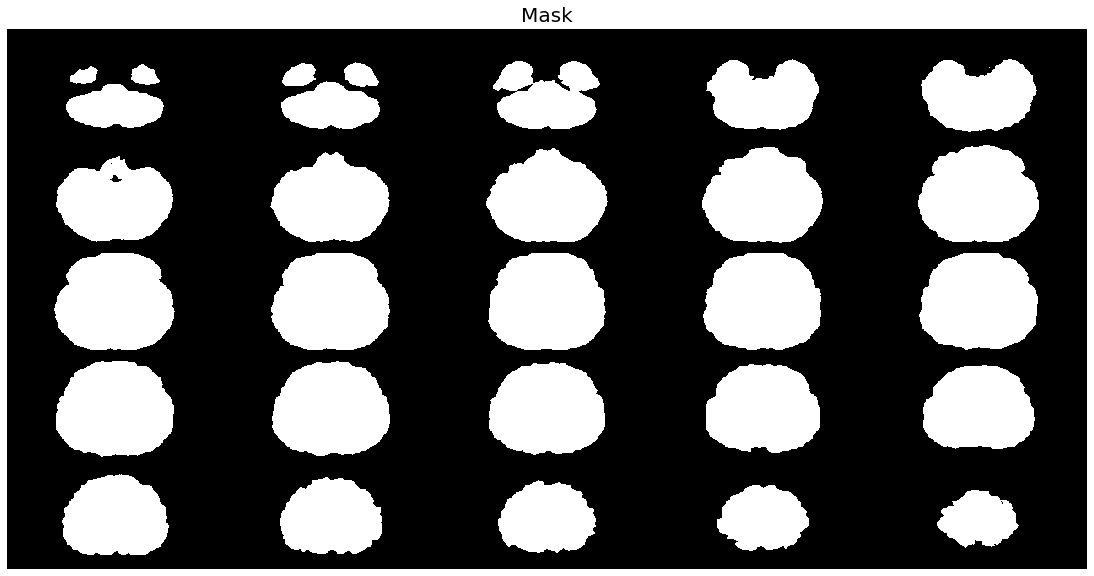

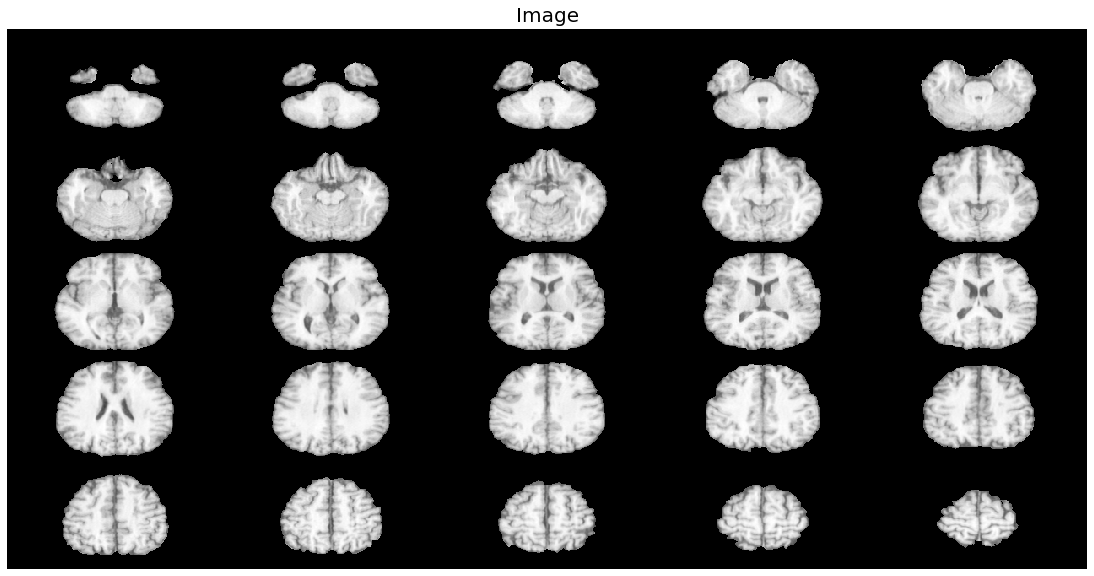

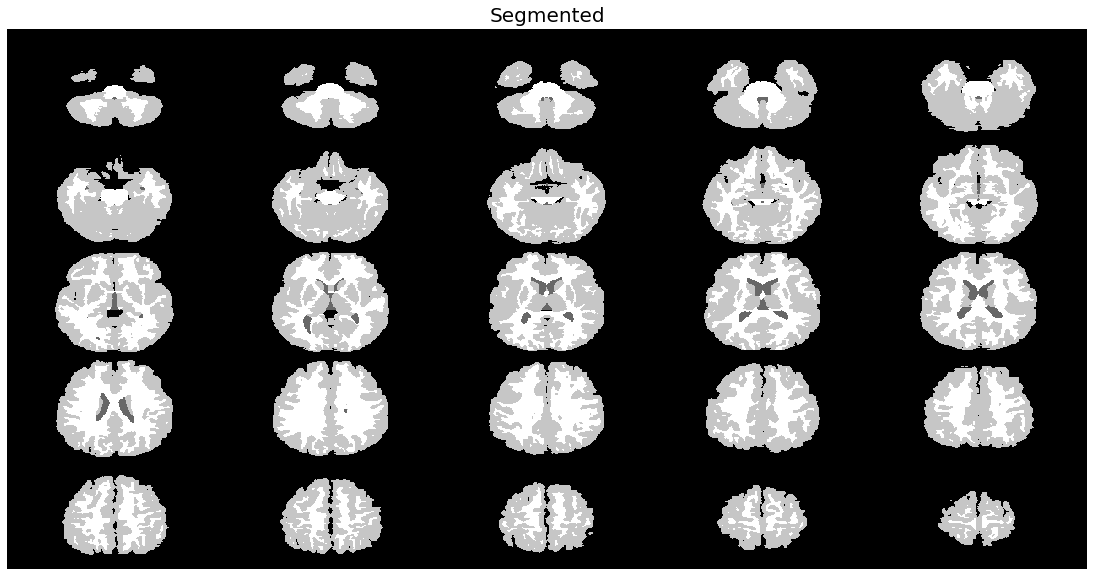

In [7]:
if options['verbose'] == True:
  mri_subject = ants.image_read('Training_Set/IBSR_01/brainmask.nii.gz')
  mri_subject.plot(nslices=25, axis=2, title='Mask')

  mri_subject = ants.image_read('Training_Set/IBSR_01/IBSR_01.nii.gz')
  mri_subject.plot(nslices=25, axis=2, title='Image')

  mri_subject = ants.image_read('Training_Set/IBSR_01/IBSR_01_seg.nii.gz')
  mri_subject.plot(nslices=25, axis=2, title='Segmented')

### Paths for Training and Validation Data being generated

In [0]:
training_data = os.listdir(options['training_path'])
validation_data = os.listdir(options['val_path'])
test_data = os.listdir(options['test_path'])

input_train_data = {scan: [os.path.join(options['training_path'],scan, scan + ".nii.gz")]
                  for scan in training_data}

input_train_labels = {scan: [os.path.join(options['training_path'],scan, scan + "_seg.nii.gz")]
                  for scan in training_data}

input_train_rois = {scan: [os.path.join(options['training_path'], scan, options['roi'])] 
                      for scan in training_data}
# validation
input_val_data = {scan: [os.path.join(options['val_path'],scan, scan + ".nii.gz")]
                  for scan in validation_data}

input_val_labels = {scan: [os.path.join(options['val_path'],scan, scan + "_seg.nii.gz")]
                  for scan in validation_data}

input_val_rois = {scan: [os.path.join(options['val_path'], scan , options['roi'])] 
                      for scan in validation_data}

# testing
if options['test_split'] == True:
  input_test_data = {scan: [os.path.join(options['test_path'],scan, scan + ".nii.gz")]
                    for scan in test_data}

  input_test_labels = {scan: [os.path.join(options['test_path'],scan, scan + "_seg.nii.gz")]
                    for scan in test_data}

  input_test_rois = {scan: [os.path.join(options['test_path'], scan , options['roi'])] 
                        for scan in test_data}

In [9]:
options

{'batch_size': 32,
 'normalize': True,
 'patch_size': (32, 32, 32),
 'patience': 30,
 'preprocess': False,
 'roi': 'brainmask.nii.gz',
 'sampling_step': (16, 16, 16),
 'single_label': False,
 'test_path': 'Test_Set',
 'test_split': False,
 'training_path': 'Training_Set',
 'val_path': 'Validation_Set',
 'verbose': True}

In [10]:
print(input_train_data)
print(input_train_labels)
print(input_train_rois)
print(input_val_data)
print(input_val_labels)
print(input_val_rois)

{'IBSR_06': ['Training_Set/IBSR_06/IBSR_06.nii.gz'], 'IBSR_09': ['Training_Set/IBSR_09/IBSR_09.nii.gz'], 'IBSR_18': ['Training_Set/IBSR_18/IBSR_18.nii.gz'], 'IBSR_07': ['Training_Set/IBSR_07/IBSR_07.nii.gz'], 'IBSR_03': ['Training_Set/IBSR_03/IBSR_03.nii.gz'], 'IBSR_05': ['Training_Set/IBSR_05/IBSR_05.nii.gz'], 'IBSR_04': ['Training_Set/IBSR_04/IBSR_04.nii.gz'], 'IBSR_01': ['Training_Set/IBSR_01/IBSR_01.nii.gz'], 'IBSR_16': ['Training_Set/IBSR_16/IBSR_16.nii.gz'], 'IBSR_08': ['Training_Set/IBSR_08/IBSR_08.nii.gz']}
{'IBSR_06': ['Training_Set/IBSR_06/IBSR_06_seg.nii.gz'], 'IBSR_09': ['Training_Set/IBSR_09/IBSR_09_seg.nii.gz'], 'IBSR_18': ['Training_Set/IBSR_18/IBSR_18_seg.nii.gz'], 'IBSR_07': ['Training_Set/IBSR_07/IBSR_07_seg.nii.gz'], 'IBSR_03': ['Training_Set/IBSR_03/IBSR_03_seg.nii.gz'], 'IBSR_05': ['Training_Set/IBSR_05/IBSR_05_seg.nii.gz'], 'IBSR_04': ['Training_Set/IBSR_04/IBSR_04_seg.nii.gz'], 'IBSR_01': ['Training_Set/IBSR_01/IBSR_01_seg.nii.gz'], 'IBSR_16': ['Training_Set/IBSR

### Training and Validation Generator

In [11]:
from MAIA_seminar.utils import MRI_DataPatchLoader
from torch.utils.data import DataLoader


print('Training data: ')
training_dataset = MRI_DataPatchLoader(input_data=input_train_data,
                                       labels=input_train_labels,
                                       rois=input_train_rois,
                                       patch_size=options['patch_size'],
                                       sampling_step=options['sampling_step'],
                                       normalize=options['normalize'])

training_dataloader = DataLoader(training_dataset, 
                                 batch_size=options['batch_size'],
                                 shuffle=True)

print('Validation data: ')
validation_dataset = MRI_DataPatchLoader(input_data=input_val_data,
                                        labels=input_val_labels,
                                        rois=input_val_rois,
                                        patch_size=options['patch_size'],
                                        sampling_step=options['sampling_step'],
                                        normalize=options['normalize'])

validation_dataloader = DataLoader(validation_dataset, 
                                   batch_size=options['batch_size'],
                                   shuffle=True)

Training data: 
> DATA: Loaded scan IBSR_06 roi size: 1078395 label_size:  977824
> DATA: Loaded scan IBSR_09 roi size: 1002429 label_size:  927415
> DATA: Loaded scan IBSR_18 roi size: 1668281 label_size:  1590195
> DATA: Loaded scan IBSR_07 roi size: 867764 label_size:  799514
> DATA: Loaded scan IBSR_03 roi size: 951358 label_size:  899576
> DATA: Loaded scan IBSR_05 roi size: 1040178 label_size:  950111
> DATA: Loaded scan IBSR_04 roi size: 1069342 label_size:  1027700
> DATA: Loaded scan IBSR_01 roi size: 1147470 label_size:  1093813
> DATA: Loaded scan IBSR_16 roi size: 1460808 label_size:  1385945
> DATA: Loaded scan IBSR_08 roi size: 868943 label_size:  787260
> DATA: Training sample size: 2745
Validation data: 
> DATA: Loaded scan IBSR_13 roi size: 1058473 label_size:  1022741
> DATA: Loaded scan IBSR_11 roi size: 958119 label_size:  889996
> DATA: Loaded scan IBSR_17 roi size: 1565803 label_size:  1502254
> DATA: Loaded scan IBSR_12 roi size: 954168 label_size:  861321
> DATA

## Defining the Model

In [0]:
import torch
import torch.nn as nn

from functools import partial
from dataclasses import dataclass
from collections import OrderedDict


class Conv3dAuto(nn.Conv3d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2, self.kernel_size[2] // 3) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv3dAuto, kernel_size=3, bias=False)

def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        #print("a:",residual)
        if self.should_apply_shortcut:
           residual = self.shortcut(x)
           #print("b:",residual)
        x = self.blocks(x)
        #print("c:",x)
        x += residual
        #print("d:",x)
        x = self.activate(x)
        #print("f:",x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels


class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv3d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.InstanceNorm3d(self.expanded_channels)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels



def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.InstanceNorm3d(out_channels))

class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x


### Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Unet(nn.Module):
    """
    Basic U-net model
    """

    def __init__(self, input_size, output_size, p=0.0):

        super(Unet, self).__init__()

        self.drop_layer = nn.Dropout(p=p)

        # conv1 down
        self.conv1 = ResNetBasicBlock(input_size, 32)

        # max-pool 1
        self.pool1 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=2,
                               stride=2)
        # conv2 down
        self.conv2 = ResNetBasicBlock(32, 64)

        # max-pool 2
        self.pool2 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=2,
                               stride=2)
        # conv3 down
        self.conv3 = ResNetBasicBlock(64,128)
        
        # max-pool 3
        self.pool3 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=2,
                               stride=2)
        
        # conv4 down 
        self.conv4 = ResNetBasicBlock(128,256)

        # max-pool 4
        self.pool4 = nn.Conv3d(in_channels=256,
                               out_channels=256,
                               kernel_size=2,
                               stride=2)       

        # conv5 down (latent space)
        self.conv5x = ResNetBasicBlock(256,512)


        # up-sample conv5
        self.up0 = nn.ConvTranspose3d(in_channels=512,
                                      out_channels=256,
                                      kernel_size=2,
                                      stride=2)  
         
        self.conv5a = ResNetBasicBlock(256,256)

        # up-sample conv4
        self.up1 = nn.ConvTranspose3d(in_channels=256,
                                      out_channels=128,
                                      kernel_size=2,
                                      stride=2)        

         
        # conv 5 (add up1 + conv3)
        self.conv5 = ResNetBasicBlock(128,128)

        # up-sample conv5
        self.up2 = nn.ConvTranspose3d(in_channels=128,
                                      out_channels=64,
                                      kernel_size=2,
                                      stride=2)
 

        # conv6 (add up2 + conv2) 
        self.conv6 = ResNetBasicBlock(64,64)

        # up 3
        self.up3 = nn.ConvTranspose3d(in_channels=64,
                                      out_channels=32,
                                      kernel_size=2,
                                      stride=2)


        # conv7 (add up3 + conv1)
        self.conv7 = ResNetBasicBlock(32,32)
        
        # conv8 (classification)
        self.conv8 = nn.Conv3d(in_channels=32,
                               out_channels=output_size,
                               kernel_size=1)

    def forward(self, x):

        # encoder
        x1 = self.drop_layer(F.relu(self.conv1(x)))

        x1p = self.pool1(x1)
        
        x2 = self.drop_layer(F.relu(self.conv2(x1p)))

        x2p = self.pool2(x2)

        x3 = self.drop_layer(F.relu(self.conv3(x2p)))

        x3p = self.pool3(x3)
        
        x4 = self.drop_layer(F.relu(self.conv4(x3p)))

        x4p = self.pool4(x4)

        # latent space
        x5a = self.drop_layer(F.relu(self.conv5x(x4p)))

        # decoder
        up0 = self.up0(x5a)

        x5b = self.drop_layer(F.relu(self.conv5a(up0 + x4)))

        up1 = self.up1(x5b)

        x5 = self.drop_layer(F.relu(self.conv5(up1 + x3)))

        up2 = self.up2(x5)

        x6 = self.drop_layer(F.relu(self.conv6(up2 + x2)))

        up3 = self.up3(x6)

        x7 = self.drop_layer(F.relu(self.conv7(up3 + x1)))

        
        # output layer (2 classes)
        # we use a softmax layer to return probabilities for each class
        out = F.softmax(self.conv8(x7), dim=1) 
        return out

## Early Stopping Class

In [0]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

## Training

In [17]:
from torch.optim import Adadelta
import time as time

def dice_coef(input, target):
    smooth = 1.

    iflat = input.reshape(-1)
    tflat = target.reshape(-1)
    intersection = (iflat * tflat).sum()
    
    return  ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

def dice_coef_multilabel(y_true, y_pred, numLabels=4):
    dice=0
    for index in range(numLabels):
      dice -= dice_coef(y_true[:,0,:,:,:] == index , y_pred[:,index,:,:,:])
      dice_total = 4 + dice
    return dice_total

def dice_coef_singlelabel(y_true, y_pred):
    index=1
    dice = -dice_coef(y_true[:,0,:,:,:] == index , y_pred[:,index,:,:,:])
    return dice

# mkdir for stored models
!mkdir models
!mkdir checkpoints

patience_es = 30
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience_es, verbose=True)
# Define the Unet model 
# 2 input channels (FLAIR and T1) - Changed it to one channel
# 2 output classes (healthy and wmh) (we ignore other pathologies) - Changed it to four since CSF,WM,GM and Background
lesion_model = Unet(input_size=1, output_size= 4, p=0.5)
model_name = 'test_maia_wmh'

# some training options
options['gpu_use'] = True
options['num_epochs'] = 300 # Changed it to 200

# define the torch.device
device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')

# define the optimizer
#optimizer = Adadelta(lesion_model.parameters())
optimizer = torch.optim.Adam(lesion_model.parameters())
# send the model to the device
lesion_model = lesion_model.to(device)

# training loop
training = True
epoch = 1
t0 = time.time()
try:
    while training:
    
        # epoch specific metrics
        train_loss = 0
        #train_accuracy = 0
        val_loss = 0
        #val_accuracy = 0
        
        # -----------------------------
        # training samples
        # -----------------------------
        
        # set the model into train mode
        lesion_model.train()
        for b, batch in enumerate(training_dataloader):
                # process batches: each batch is composed by training (x) and labels (y)
                # x = [32, 2, 32, 32, 32]
                # y = [32, 1, 32, 32, 32]
    
                x = batch[0].to(device)
                y = batch[1].to(device)
                
                # clear gradients
                optimizer.zero_grad()
                
                # infer the current batch 
                pred = lesion_model(x)
                
                # compute the loss. 
                loss = dice_coef_multilabel(y, pred)
                #loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),
                #                       y.squeeze(dim=1).long())
                #loss = dice_coef_singlelabel(y, pred)

                train_loss += loss.item()
                
                # backward loss and next step
                loss.backward()
                optimizer.step()

                # compute the accuracy
                #pred = pred.max(1, keepdim=True)[1]
                #batch_accuracy = pred.eq(y.view_as(pred).long())
                #train_accuracy += (batch_accuracy.sum().item() / np.prod(y.shape))
                
                
        # -----------------------------
        # validation samples
        # -----------------------------
    
        # set the model into train mode
        lesion_model.eval()
        for b, batch in enumerate(validation_dataloader):
                x = batch[0].to(device)
                y = batch[1].to(device)
                
                # infer the current batch 
                with torch.no_grad():
                    pred = lesion_model(x)
                
                    # compute the loss. 
                # compute the loss. 
                    #loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),
                    #                      y.squeeze(dim=1).long())
                    
                    #loss = dice_coef_singlelabel(y, pred)
                    loss = dice_coef_multilabel(y, pred)
                    val_loss += loss.item()
                
                    # compute the accuracy 
                    #pred = pred.max(1, keepdim=True)[1]
                    #batch_accuracy = pred.eq(y.view_as(pred).long())
                    #val_accuracy += batch_accuracy.sum().item() / np.prod(y.shape) 
                


        # compute mean metrics
        train_loss /= (len(training_dataloader))
        #train_accuracy /= (len(training_dataloader))
        val_loss /= (len(validation_dataloader))
        #val_accuracy /= (len(validation_dataloader))
        early_stopping(val_loss, lesion_model)
    
        if early_stopping.early_stop:
            print("Early stopping")
            break
        print('Epoch {:d} train_loss {:.4f} val_loss {:.4f} '.format(
            epoch, 
            train_loss,
            val_loss))
        
        # save weights
        torch.save(lesion_model.state_dict(), 
                  os.path.join('models', 'model' + str(epoch) + '.pt'))
        t1 = time.time()
        print('Total time: ', round((t1-t0)/60,1), 'minutes.\n')
        

        if epoch >= options['num_epochs']:
            training = False
        
        # update epochs
        epoch += 1

except KeyboardInterrupt:
    pass
                        

KeyboardInterrupt: ignored

0.5 DP Res patch_step 16

### Dice Scores for the Validation

In [22]:
import pandas as pd
from MAIA_seminar.utils import get_inference_patches, reconstruct_image
from MAIA_seminar.metrics import DSC_seg, TPF_det, PPV_det
from MAIA_seminar.metrics import DSC_seg, PVE, MHD

import matplotlib.pyplot as plt
lesion_model = Unet(input_size=1, output_size= 4, p=0.5)
lesion_model = lesion_model.to(device)

options['sampling_step'] = (8,8,8)
if 1:
  print('we load the best loss epoch')
  lesion_model.load_state_dict(torch.load('checkpoint.pt'))
else:
  best_ep = 109
  print('We load epoch', best_ep)
  lesion_model.load_state_dict(torch.load('models/model'+str(best_ep)+'.pt'))

# obtain a list of test scans
test_scans = os.listdir(options['val_path'])
th = 0.5
count = 0
# iterate through the scans and evaluate the results
metrics = np.zeros((len(test_scans), 3))
metrics_AVD = np.zeros((len(test_scans), 3))
metrics_Hausdorff = np.zeros((len(test_scans), 3))
for i, scan_name in enumerate(test_scans):

    print('analysing', scan_name)
    scan_path = os.path.join(options['val_path'], scan_name)
    scan = ants.image_read(os.path.join(scan_path, scan_name + '.nii.gz'))
    roi = nib.load(os.path.join(scan_path, 'brainmask' + '.nii.gz')).get_data()
    img = scan_name + '.nii.gz'

    infer_patches, coordenates = get_inference_patches(scan_path=scan_path,
                                              input_data=list([img]),
                                              roi='brainmask.nii.gz',
                                              patch_shape=options['patch_size'],
                                              step=options['sampling_step'],
                                              normalize=options['normalize'])

    d_wm = np.zeros_like(infer_patches).astype('float32')
    d_csf = d_wm.copy()
    d_gm = d_wm.copy()
    d_bg = d_wm.copy()

    batch_size = options['batch_size']

    # model evaluation 
    labb = 2
    lesion_model.eval()
    with torch.no_grad():
        for b in range(0, len(d_wm), batch_size):
            x = torch.tensor(infer_patches[b:b+batch_size]).to(device)
            pred = lesion_model(x)
            # HERE WE SHOULD BUILD A 1 CHANNEL, 4 INTENSITY VALUES (0,1,2,3) OUTPUT
            # ... or save a 4 channel output to do this later on
            # For option (A) we could binarise each channel according to the max prob, and then merge with weights
       #     for lay in range(1,4):
       #       pred[:,lay] = pred[:,lay] == max(pred[:,:])
       #     segg = pred[:,1] + 2*pred[:,2] + 3*pred[:,3]
            d_bg[b:b+batch_size][:,0] = pred[:,0].cpu().numpy()           
            d_csf[b:b+batch_size][:,0] = pred[:,1].cpu().numpy()
            d_gm[b:b+batch_size][:,0] = pred[:,2].cpu().numpy()
            d_wm[b:b+batch_size][:,0] = pred[:,3].cpu().numpy()
        
    # reconstruct image 
    lesion_prob0 = reconstruct_image(d_bg[:,0],
                                    coordenates, 
                                    scan.shape)
    
    lesion_prob1 = reconstruct_image(d_csf[:,0],
                                    coordenates, 
                                    scan.shape)
    lesion_prob2 = reconstruct_image(d_gm[:,0],
                                    coordenates, 
                                    scan.shape)
    lesion_prob3 = reconstruct_image(d_wm[:,0],
                                    coordenates, 
                                    scan.shape)
            

    # binarize the results
    # Assign the maximum Probability label
    pred_gt = np.zeros(lesion_prob1.shape)
    if 0:
      pred_gt = (lesion_prob1 > 0.5) * 1 #np.greater(lesion_prob1,lesion_prob0) * np.greater(lesion_prob1,lesion_prob2) * np.greater(lesion_prob1,lesion_prob3) * roi * 1
      pred_gt += (lesion_prob2 > 0.5) * 2 #np.greater(lesion_prob2,lesion_prob0) * np.greater(lesion_prob2,lesion_prob1) * np.greater(lesion_prob2,lesion_prob3) * roi * 2
      pred_gt += (lesion_prob3 > 0.5) * 3  #np.greater(lesion_prob3,lesion_prob0) * np.greater(lesion_prob3,lesion_prob1) * np.greater(lesion_prob3,lesion_prob2) * roi * 3
    else:
      #lesion_prob1 *= 1.1
      pred_gt = np.greater(lesion_prob1,lesion_prob0) * np.greater(lesion_prob1,lesion_prob2) * np.greater(lesion_prob1,lesion_prob3) * roi * 1
      pred_gt += np.greater(lesion_prob2,lesion_prob0) * np.greater(lesion_prob2,lesion_prob1) * np.greater(lesion_prob2,lesion_prob3) * roi * 2
      pred_gt += np.greater(lesion_prob3,lesion_prob0) * np.greater(lesion_prob3,lesion_prob1) * np.greater(lesion_prob3,lesion_prob2) * roi * 3

    pred_gt = pred_gt * roi

    # evaluate the results    
    gt = ants.image_read(os.path.join(scan_path, scan_name + '_seg.nii.gz'))
    
    if 0:
      print(pred_gt.shape)

      plt.figure()
      plt.subplot(1,4,1)
      plt.imshow(pred_gt[:,:,144] == 1)
      plt.title("CSF")

      plt.subplot(1,4,2)
      plt.imshow(pred_gt[:,:,144] == 2)
      plt.title("Grey Matter")

      plt.subplot(1,4,3)
      plt.imshow(pred_gt[:,:,144] == 3)
      plt.title("White Matter")
      
      plt.subplot(1,4,4)
      plt.imshow(gt.numpy()[:,:,144])
      plt.title("Ground Truth")
      plt.show()
       
    test_ground = gt.numpy()
    dsc_metric1 = DSC_seg((gt.numpy()==1 ), pred_gt == 1)
    dsc_metric2 = DSC_seg(gt.numpy() == 2, pred_gt ==  2)
    dsc_metric3 = DSC_seg(gt.numpy() == 3, pred_gt ==  3)

    metrics[i] = [dsc_metric1, dsc_metric2, dsc_metric3]
        
    print('SCAN:', scan_name, 'Dice_csf: ', dsc_metric1, 'Dice_gm:', dsc_metric2, 'Dice_wm:', dsc_metric3)

    a = pred_gt == 1
    b = pred_gt == 2
    c = pred_gt == 3
    avg1 = PVE(test_ground ==1, a , type='absolute')
    avg2 = PVE(test_ground ==2, b , type='absolute')
    avg3 = PVE(test_ground ==3, c , type='absolute')

    
    
    temp = nib.load("/content/Validation_Set/"+scan_name +"/" + scan_name  +  ".nii.gz")
    hf1 = MHD(test_ground ==1, a , spacing=temp.header.get_zooms()[:3])
    hf2 = MHD(test_ground ==2, b , spacing=temp.header.get_zooms()[:3])
    hf3 = MHD(test_ground ==3, c , spacing=temp.header.get_zooms()[:3])


    metrics[count] = [dsc_metric1, dsc_metric2, dsc_metric3]
    metrics_AVD[count] = [avg1, avg2, avg3]
    metrics_Hausdorff[count] = [hf1, hf2, hf3]

    print('SCAN:', scan_name, 'Dice_csf: ', dsc_metric1, 'Dice_gm:', dsc_metric2, 'Dice_wm:', dsc_metric3)
    #print('SCAN:', scan, 'Dice_csf: ', dsc_metric1a, 'Dice_gm:', dsc_metric2a, 'Dice_wm:', dsc_metric3a)
    count +=1

m = pd.DataFrame(metrics, columns=['DSC_CSF', 'DSC_GM', 'DSC_WM'])
m.describe().T

we load the best loss epoch
analysing IBSR_13


/content/MAIA_seminar/utils.py:461: RuntimeWarning: invalid value encountered in true_divide
  out_image /= freq_count


SCAN: IBSR_13 Dice_csf:  0.9013603829928426 Dice_gm: 0.9436183625687502 Dice_wm: 0.9279486018437038
SCAN: ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 128, 256)
	 Spacing    : (0.9375, 1.5, 0.9375)
	 Origin     : (239.0625, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]
 Dice_csf:  0.9013603829928426 Dice_gm: 0.9436183625687502 Dice_wm: 0.9279486018437038
analysing IBSR_11


/content/MAIA_seminar/utils.py:461: RuntimeWarning: invalid value encountered in true_divide
  out_image /= freq_count


SCAN: IBSR_11 Dice_csf:  0.9190745986779981 Dice_gm: 0.9517507176816056 Dice_wm: 0.962495981910283
SCAN: ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 128, 256)
	 Spacing    : (1.0, 1.5, 1.0)
	 Origin     : (255.0, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]
 Dice_csf:  0.9190745986779981 Dice_gm: 0.9517507176816056 Dice_wm: 0.962495981910283
analysing IBSR_17


/content/MAIA_seminar/utils.py:461: RuntimeWarning: invalid value encountered in true_divide
  out_image /= freq_count


SCAN: IBSR_17 Dice_csf:  0.9507557289127255 Dice_gm: 0.9527108048298586 Dice_wm: 0.939975955258134
SCAN: ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 128, 256)
	 Spacing    : (0.8371, 1.5, 0.8371)
	 Origin     : (213.4487, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]
 Dice_csf:  0.9507557289127255 Dice_gm: 0.9527108048298586 Dice_wm: 0.939975955258134
analysing IBSR_12


/content/MAIA_seminar/utils.py:461: RuntimeWarning: invalid value encountered in true_divide
  out_image /= freq_count


SCAN: IBSR_12 Dice_csf:  0.9270657817819195 Dice_gm: 0.9396955155618377 Dice_wm: 0.94692533755458
SCAN: ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 128, 256)
	 Spacing    : (1.0, 1.5, 1.0)
	 Origin     : (255.0, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]
 Dice_csf:  0.9270657817819195 Dice_gm: 0.9396955155618377 Dice_wm: 0.94692533755458
analysing IBSR_14


/content/MAIA_seminar/utils.py:461: RuntimeWarning: invalid value encountered in true_divide
  out_image /= freq_count


SCAN: IBSR_14 Dice_csf:  0.9376790830945558 Dice_gm: 0.955837579742755 Dice_wm: 0.9550408332058635
SCAN: ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 128, 256)
	 Spacing    : (0.9375, 1.5, 0.9375)
	 Origin     : (239.0625, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]
 Dice_csf:  0.9376790830945558 Dice_gm: 0.955837579742755 Dice_wm: 0.9550408332058635


,count,mean,std,min,25%,50%,75%,max
DSC_CSF,5.0,0.927187,0.018698,0.901360,0.919075,0.927066,0.937679,0.950756
DSC_GM,5.0,0.948723,0.006768,0.939696,0.943618,0.951751,0.952711,0.955838
DSC_WM,5.0,0.946477,0.013376,0.927949,0.939976,0.946925,0.955041,0.962496


In [25]:
print(np.mean(np.mean(m)))

0.9407956843744941


## Average Volumetric Difference


In [26]:
k = pd.DataFrame(metrics_AVD, columns=['AVD_CSF', 'AVD_GM', 'AVD_WM'])
k.describe().T

,count,mean,std,min,25%,50%,75%,max
AVD_CSF,5.0,0.046774,0.036341,0.014285,0.018995,0.028484,0.081855,0.090251
AVD_GM,5.0,0.021818,0.016010,0.001231,0.016001,0.018264,0.029503,0.044088
AVD_WM,5.0,0.034132,0.024763,0.005473,0.015330,0.036536,0.045324,0.067997


## Hausdorff Distance

In [27]:
l = pd.DataFrame(metrics_Hausdorff, columns=['HD_CSF', 'HD_GM', 'HD_WM'])
l.describe().T

,count,mean,std,min,25%,50%,75%,max
HD_CSF,5.0,0.136111,0.054474,0.070269,0.084117,0.163955,0.179300,0.182913
HD_GM,5.0,0.078220,0.032635,0.053636,0.053849,0.069167,0.081755,0.132693
HD_WM,5.0,0.079088,0.025015,0.052670,0.061952,0.074033,0.091057,0.115729
